In [1]:
import sys
import os
cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

In [2]:
import numpy as np
import torch

In [4]:
from src.utils import load_model
model, _ = load_model('../outputs/tsp_10/rollout_20230602T185729')
model.eval()  # Put in evaluation mode to not track gradients

xy = np.random.rand(10, 2)

def make_oracle(model, xy, temperature=1.0):
    
    num_nodes = len(xy)
    
    xyt = torch.tensor(xy).float()[None]  # Add batch dimension
    
    with torch.no_grad():  # Inference only
        embeddings = model.encoder(model._init_embed(xyt))

        # Compute keys, values for the glimpse and keys for the logits once as they can be reused in every step
        fixed = model._precompute(embeddings)
    
    def oracle(tour):
        with torch.no_grad():  # Inference only
            # Input tour with 0 based indices
            # Output vector with probabilities for locations not in tour
            tour = torch.tensor(tour).long()
            if len(tour) == 0:
                step_context = model.W_placeholder
            else:
                step_context = torch.cat((embeddings[0, tour[0]], embeddings[0, tour[-1]]), -1)

            # Compute query = context node embedding, add batch and step dimensions (both 1)
            query = fixed.context_node_projected + model.decoder.project_step_context(step_context[None, None, :])

            # Create the mask and convert to bool depending on PyTorch version
            mask = torch.zeros(num_nodes, dtype=torch.uint8) > 0
            mask[tour] = 1
            mask = mask[None, None, :]  # Add batch and step dimension

            log_p, _ = model.decoder.get_attention_glimpse(query, fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key, mask)
            p = torch.softmax(log_p / temperature, -1)[0, 0]
            assert (p[tour] == 0).all()
            assert (p.sum() - 1).abs() < 1e-5
            #assert np.allclose(p.sum().item(), 1)
        return p.numpy()
    
    return oracle
        


oracle = make_oracle(model, xy)

sample = False
tour = []
tour_p = []
while(len(tour) < len(xy)):
    p = oracle(tour)
    
    if sample:
        # Advertising the Gumbel-Max trick
        g = -np.log(-np.log(np.random.rand(*p.shape)))
        i = np.argmax(np.log(p) + g)
        # i = np.random.multinomial(1, p)
    else:
        # Greedy
        i = np.argmax(p)
    tour.append(i)
    tour_p.append(p)
    
print(tour)

  [*] Loading model from ../outputs/tsp_10/rollout_20230602T185729/epoch-4.pt
[3, 0, 6, 7, 2, 1, 9, 4, 5, 8]


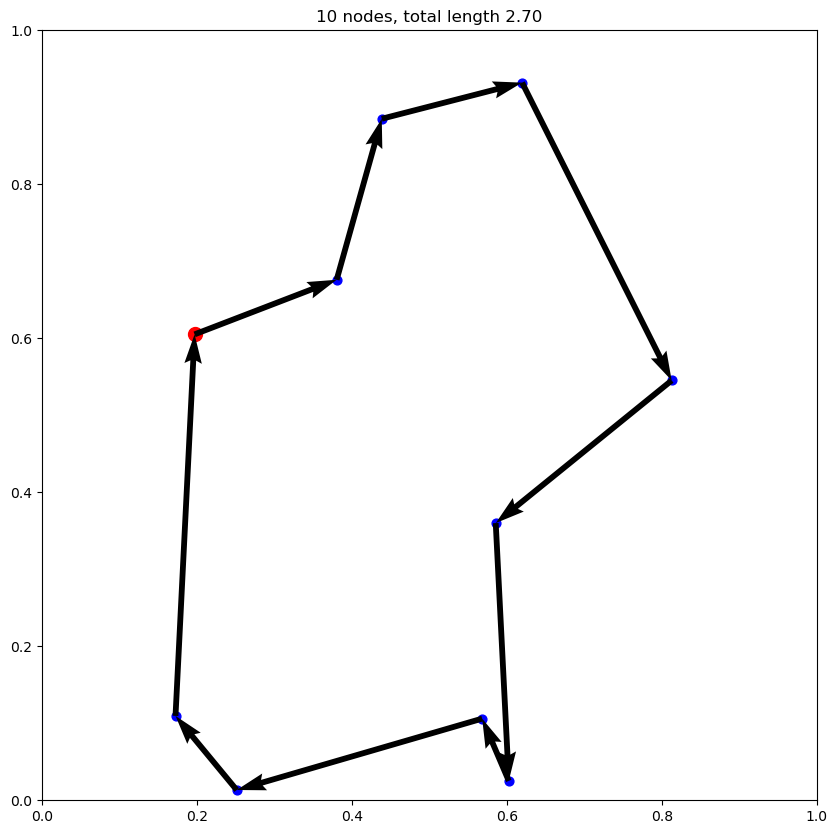

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    xs, ys = xy[tour].transpose()
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{} nodes, total length {:.2f}'.format(len(tour), lengths[-1]))
    
fig, ax = plt.subplots(figsize=(10, 10))
plot_tsp(xy, tour, ax)


MovieWriter imagemagick unavailable; using Pillow instead.



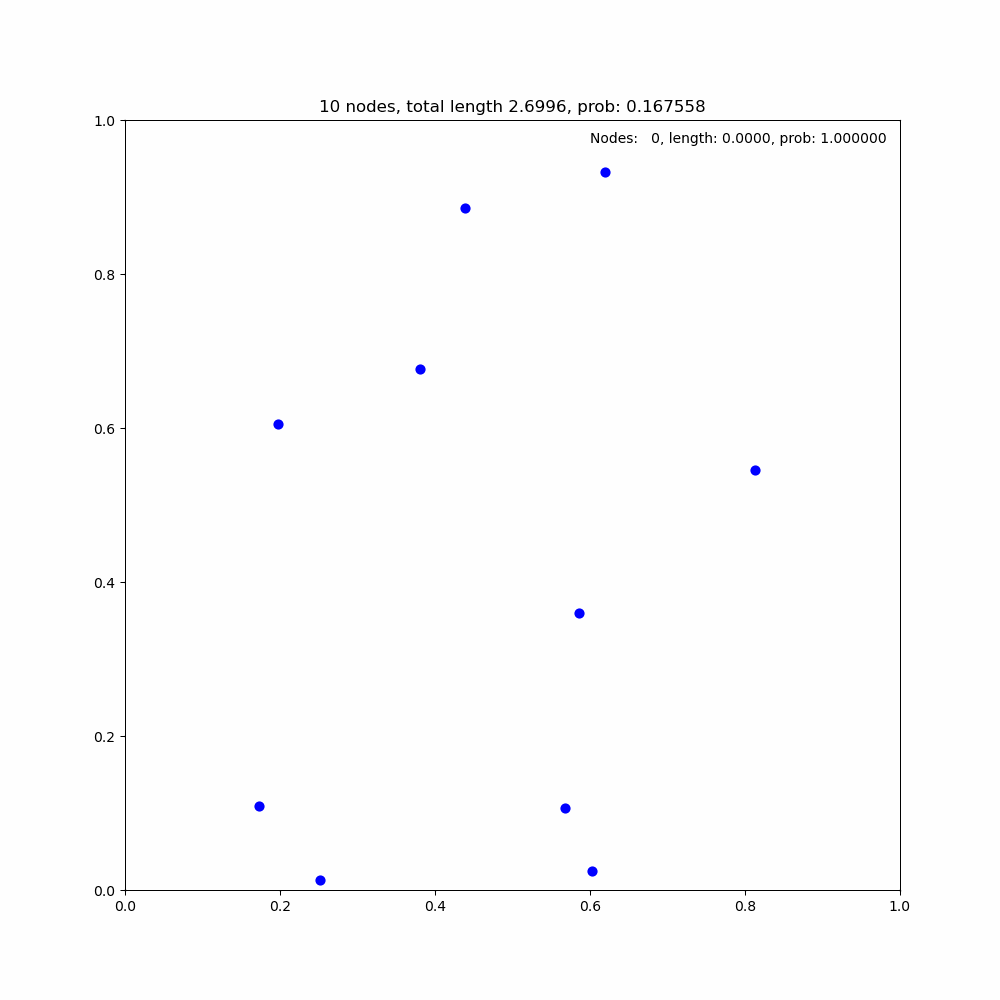

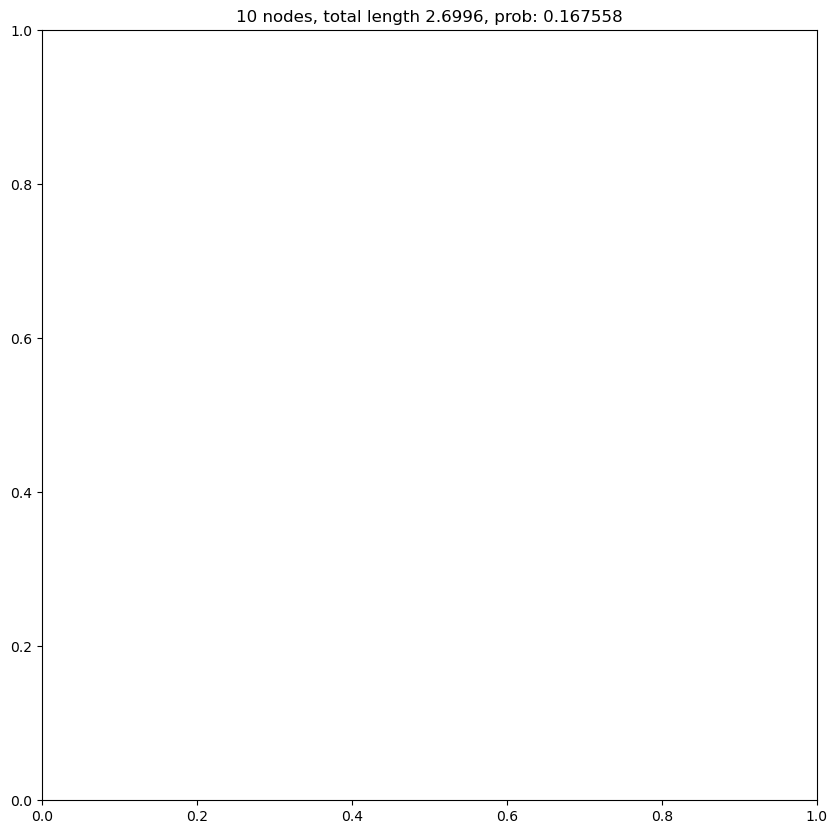

In [6]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import HTML
import base64

from celluloid import Camera  # pip install celluloid

def format_prob(prob):
    return ('{:.6f}' if prob > 1e-5 else '{:.2E}').format(prob)

def plot_tsp_ani(xy, tour, tour_p=None, max_steps=1000):
    n = len(tour)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    camera = Camera(fig)

    total_length = 0
    cum_log_prob = 0
    for i in range(n + 1):
        for plot_probs in [False] if tour_p is None or i >= n else [False, True]:
            # Title
            title = 'Nodes: {:3d}, length: {:.4f}, prob: {}'.format(
                i, lengths[i - 2] if i > 1 else 0., format_prob(np.exp(cum_log_prob))
            )
            ax1.text(0.6, 0.97, title, transform=ax.transAxes)

            # First print current node and next candidates
            ax1.scatter(xs, ys, s=40, color='blue')

            if i > 0:
                ax1.scatter([xs[i - 1]], [ys[i - 1]], s=100, color='red')
            if i > 1:
                qv = ax1.quiver(
                    xs[:i-1],
                    ys[:i-1],
                    dx[:i-1],
                    dy[:i-1],
                    scale_units='xy',
                    angles='xy',
                    scale=1,
                )
            if plot_probs:
                prob_rects = [Rectangle((x, y), 0.01, 0.1 * p) for (x, y), p in zip(xy, tour_p[i]) if p > 0.01]
                pc = PatchCollection(prob_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
                ax1.add_collection(pc)
            camera.snap()
        if i < n and tour_p is not None:
            # Add cumulative_probability
            cum_log_prob += np.log(tour_p[i][tour[i]])
        if i > max_steps:
            break

    # Plot final tour
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    if tour_p is not None:
        # Note this does not use stable logsumexp trick
        cum_log_prob = format_prob(np.exp(sum([np.log(p[node]) for node, p in zip(tour, tour_p)])))
    else:
        cum_log_prob = '?'
    ax1.set_title('{} nodes, total length {:.4f}, prob: {}'.format(len(tour), lengths[-1], cum_log_prob))
    
    camera.snap()
    
    return camera 

    
animation = plot_tsp_ani(xy, tour, tour_p).animate(interval=500)
animation.save('../images/tsp/tsp.gif', writer='imagemagick', fps=2)  # requires imagemagick
# compress by running 'convert tsp.gif -strip -coalesce -layers Optimize tsp.gif'
# HTML(animation.to_html5_video())  # requires ffmpeg
b64 = base64.b64encode(open('../images/tsp/tsp.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))